<center>
<img src="img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
</center>
Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

Зафиксируем заранее `random_state` (a.k.a. random seed). Это должно повысить вероятность полной воспроизводимости результатов, впрочем, замечено, что тем не менее небольшие флуктуации возможны (например, качества прогнозов дерева, которое мы сейчас вырастим) в случае разных ОС.

In [3]:
RANDOM_STATE = 17

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [4]:
import numpy as np
import math as mt
from sklearn.base import BaseEstimator


class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='entropy', debug=False):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.debug = debug
        self.criterion = criterion

    def fit(self, X, y):
        if self.criterion=='entropy':
            self.criterion_func = self._entropy
            self.type_answer = 'max_count'
        elif self.criterion=='gini':
            self.criterion_func = self._gini
            self.type_answer = 'max_count'
        elif self.criterion=='variance':
            self.criterion_func = self._variance
            self.type_answer = 'avg'
        elif self.criterion=='mad_median':
            self.criterion_func = self._mad_median
            self.type_answer = 'avg'
        data = np.c_[X, y]
        self.y_var = np.unique(y, axis=0)
        self.tree = np.array(self._get_tree(data, '1'))

    def predict(self, X):
        y = []
        for line in X:
            answer = self._get_leaf(line,'1')
            y.append(self._get_answer_val(answer))
        y = np.array(y)
        return(y)

    def predict_proba(self, X):
        y = []
        for line in X:
            answer = self._get_leaf(line,'1')
            var_answer = answer[:,0]
            dif_var = np.array(np.setdiff1d(self.y_var, var_answer))
            p_0 = np.array([0 for x in range(len(dif_var))])
            dif = np.c_[dif_var, p_0]
            answer = np.append(answer, dif, axis=0)
            answer = answer[answer[:,0].argsort()]
            y.append(answer[:,1])
        y = np.array(y)
        return(y)

    # Функции оценки
    def _entropy(self, y):
        proba = self._get_proba(y)
        entropy = 0
        for p in proba:
            entropy -= p[1]*mt.log(p[1], 2)
        return(entropy)

    def _gini(self, y):
        proba = self._get_proba(y)
        gini = 1
        for p in proba:
            gini -= p[1]**2
        return(gini)

    def _variance(self, y):
        variance = y.std()**2
        return(variance)

    def _mad_median(self, y):
        sum_dif_median = (np.abs(y - np.median(y))).sum()
        mad_median = sum_dif_median/y.shape[0]
        return(mad_median)

    def _get_proba(self, y):
        val, count = np.unique(y, return_counts=True, axis=0)
        value_count = np.c_[val, count]
        count_y = y.shape[0]
        proba = np.c_[value_count[:,0], value_count[:,1]/count_y]
        return(proba)
    
    # Построение дерева
    def _information_gain(self, data, data_left, data_right):
        count = data.shape[0]
        count_left = data_left.shape[0]
        count_right = data_right.shape[0]
        fval = self.criterion_func(data)
        fval_left = self.criterion_func(data_left)
        fval_right = self.criterion_func(data_right)
        ig = fval - fval_left*count_left/count - fval_right*count_right/count
        return(ig)

    def _best_split(self, data):
        index_y = data.shape[1]-1
        best_split = {'ig': 0, 'column': 0, 'val': 0}
        for i in range(index_y):
            unique_val = np.unique(data[:, i], axis=0)
            unique_val = np.sort(unique_val)[:-1]
            for val in unique_val:
                data_left = data[data[:,i]<=val]
                data_right = data[data[:,i]>val]
                ig = self._information_gain(data[:, index_y], data_left[:, index_y], data_right[:, index_y])
                
                if ig > best_split['ig']:
                    best_split['ig'] = ig
                    best_split['column'] = i
                    best_split['val'] = val
        if best_split['ig'] == 0:
            return(False)
        else:
            return(best_split)

    def _chek_y(self, data):
        unique_val = np.unique(data[:,-1], axis=0)
        answer = True if unique_val.shape[0]>1 else False
        return(answer)

    def _get_tree(self, data, id_tree):
        split = data.shape[0]>=self.min_samples_split \
                    and self._chek_y(data) \
                    and self._best_split(data)
        if split and len(id_tree) < self.max_depth:
            # Деление ветвей
            id_tree_left = id_tree + '1'
            id_tree_right = id_tree + '2'
            tree = [[id_tree,
                    {'column': split['column'], 
                     'val': split['val'],
                     'id_left': id_tree_left,
                     'id_right': id_tree_right,
                     'is_leaf' : False,
                     'leaf_data': None}]]
            data_left = data[data[:,split['column']]<=split['val']]
            data_right = data[data[:,split['column']]>split['val']]
            tree.extend(self._get_tree(data_left, id_tree_left))
            tree.extend(self._get_tree(data_right, id_tree_right))
            return(tree)
        else:
            # Формирование листа дерева
            proba = self._get_proba(data[:,-1])
            tree = [[id_tree,
                    {'column': None, 
                     'val': None,
                     'id_left': None,
                     'id_right': None,
                     'is_leaf' : True,
                     'leaf_data': proba}]]
        return(tree)

    # Поиск решения по дереву
    def _get_leaf(self, line, id_tree):
        instruction = self.tree[self.tree[:,0]==id_tree][0][1]
        if instruction['is_leaf']:
            return(instruction['leaf_data'])
        else:
            if line[instruction['column']]<=instruction['val']:
                return(self._get_leaf(line, instruction['id_left']))
            else:
                return(self._get_leaf(line, instruction['id_right']))

    def _get_answer_val(self, answer_arr):
        if self.type_answer == 'max_count':
            answer = answer_arr[answer_arr[:,1].argsort()]
            answer = answer[-1][0]
            return(answer)
        elif self.type_answer == 'avg':
            answer = answer_arr[:,0]*answer_arr[:,1]
            answer = answer.sum()
            return(answer)

## Тестирование реализованного алгоритма

### Классификация

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [5]:
data = load_digits()
X, y = data.data, data.target
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=17)

С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [25]:
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTree
tree_params = {'max_depth': [x for x in range(3, 11)], 'criterion': ['gini', 'entropy']}
tree_digits = GridSearchCV(estimator(), tree_params, cv=5, n_jobs=1, scoring='accuracy', iid=False, verbose=1)
tree_digits.fit(X_train, y_train)
tree_digits.best_params_, tree_digits.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 16.6min finished


({'criterion': 'entropy', 'max_depth': 9}, 0.8670852690669764)

Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

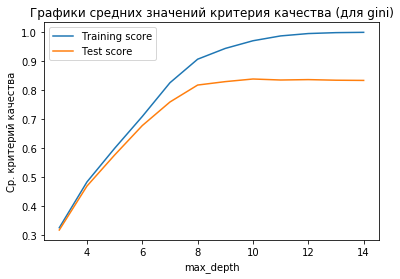

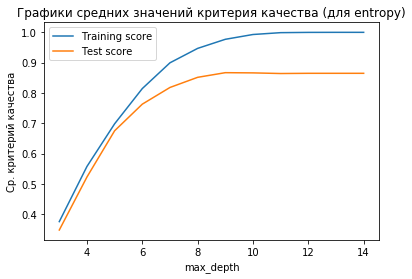

In [27]:
from sklearn.model_selection import validation_curve

estimator = DecisionTree
param_range = np.array([x for x in range(3, 15)])
for criterion in ['gini', 'entropy']:
    train_scores, test_scores = validation_curve(estimator=estimator(criterion=criterion),
                                     X=X_train, 
                                     y=y_train,
                                     param_name='max_depth',
                                     param_range=param_range,
                                     cv=5, scoring="accuracy", n_jobs=3, verbose=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.title(f'Графики средних значений критерия качества (для {criterion})')
    plt.xlabel("max_depth")
    plt.ylabel("Ср. критерий качества")
    plt.plot(param_range, train_scores_mean, label="Training score")
    plt.plot(param_range, test_scores_mean, label="Test score")
    plt.legend(loc="best")
    plt.show()


**Выберите верные утверждения:**
1. Оптимальное значение `max_depth` для каждого критерия достигается на отрезке [4, 9].
2. На отрезке [3, 10] построенные графики не пересекаются.
3. На отрезке [3, 10] построенные графики пересекаются ровно один раз.
4. Наилучшее качество при `max_depth` на интервале [3, 10] достигается при использовании критерия `gini`.
5. Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения `max_depth` на интервале [3, 10].

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [30]:
import pandas as pd

In [32]:
tree_d = DecisionTree(max_depth=9, criterion='entropy')
tree_d.fit(X_train, y_train)

In [42]:
tree_d_pred = tree_d.predict(X_holdout)
result = np.c_[tree_d_pred, y_holdout]
pd.DataFrame(result).head()

,0,1
0,1.0,1.0
1,8.0,2.0
2,7.0,7.0
3,3.0,3.0
4,9.0,9.0


Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

In [52]:
tree_d_predict_proba = tree_d.predict_proba(X_holdout)
proba = np.sort(tree_d_predict_proba, axis=1)[:,-1]
proba.mean(), proba.max()

(0.9720841959972394, 1.0)

**Вопрос:** Чему примерно равна максимальная вероятность в полученном векторе?
1. 0.127
2. 0.118
3. 1.0
4. 0.09

### Регрессия

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [68]:
data = load_boston()
X, y = data.data, data.target
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=17)

С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [105]:
from sklearn.tree import DecisionTreeRegressor

estimator = DecisionTree
tree_params_boston = {'max_depth': [x for x in range(2, 9)], 'criterion': ['variance', 'mad_median']}
tree_boston = GridSearchCV(estimator(), tree_params_boston, cv=5, n_jobs=2, 
                           scoring='neg_mean_squared_error', verbose=1, iid=False)
tree_boston.fit(X_train, y_train)
tree_boston.best_params_, tree_boston.best_score_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   24.9s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:   54.7s finished
c:\users\stanislav.lyunchenko\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'criterion': 'variance', 'max_depth': 6}, -24.451356749318844)

Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  65 out of  65 | elapsed:   44.1s finished


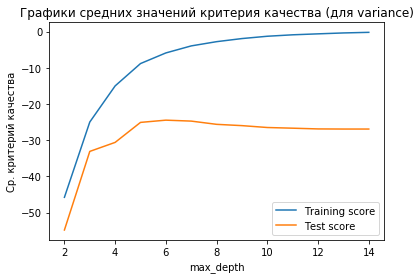

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  65 out of  65 | elapsed:  1.4min finished


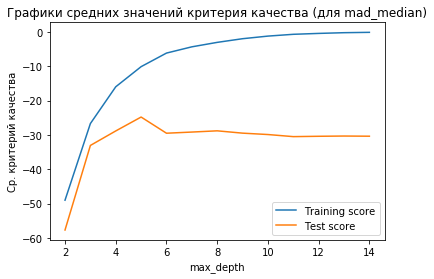

In [109]:
from sklearn.model_selection import validation_curve

estimator = DecisionTree
param_range_boston = np.array([x for x in range(2, 15)])
for criterion in ['variance', 'mad_median']:
    train_scores, test_scores = validation_curve(estimator=estimator(criterion=criterion),
                                     X=X_train, 
                                     y=y_train,
                                     param_name='max_depth',
                                     param_range=param_range_boston,
                                     cv=5, scoring='neg_mean_squared_error', n_jobs=3, verbose=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.title(f'Графики средних значений критерия качества (для {criterion})')
    plt.xlabel("max_depth")
    plt.ylabel("Ср. критерий качества")
    plt.plot(param_range_boston, train_scores_mean, label="Training score")
    plt.plot(param_range_boston, test_scores_mean, label="Test score")
    plt.legend(loc="best")
    plt.show()

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  65 out of  65 | elapsed:    0.1s finished


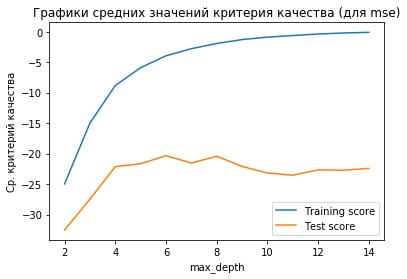

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  65 out of  65 | elapsed:    0.4s finished


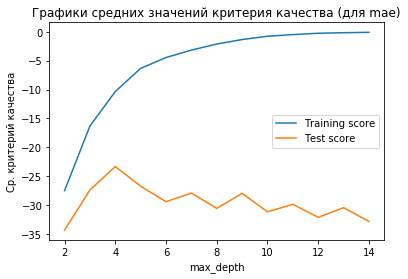

In [108]:
from sklearn.model_selection import validation_curve
DecisionTreeRegressor
estimator = DecisionTreeRegressor
param_range_boston = np.array([x for x in range(2, 15)])
for criterion in ['mse', 'mae']:
    train_scores, test_scores = validation_curve(estimator=estimator(criterion=criterion),
                                     X=X_train, 
                                     y=y_train,
                                     param_name='max_depth',
                                     param_range=param_range_boston,
                                     cv=5, scoring='neg_mean_squared_error', n_jobs=3, verbose=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.title(f'Графики средних значений критерия качества (для {criterion})')
    plt.xlabel("max_depth")
    plt.ylabel("Ср. критерий качества")
    plt.plot(param_range_boston, train_scores_mean, label="Training score")
    plt.plot(param_range_boston, test_scores_mean, label="Test score")
    plt.legend(loc="best")
    plt.show()

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются.
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз.
3. Оптимальное значение `max_depth` для каждого из критериев достигается на границе отрезка [2, 8].
4. Наилучшее качество при `max_depth` из [2, 8] достигается при использовании критерия `mad_median`.

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance';